In [31]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [97]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 #initialing learning rate
EPOCHS = 20
BS = 32 #i use this variable instead of writting 32

In [98]:
DIRECTORY = 'dataset/'#rather than using link i use where is my dataset havae
CATEGORIES = ["with_mask", "without_mask"] #it will detect by default 1 and 0

In [99]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []#all the images we have and store it array format
labels = []#all the corresponding label with mask and without mask

for category in CATEGORIES:#basically i in for loop
    path = os.path.join(DIRECTORY, category)#i have found my path where my file is stored
    for img in os.listdir(path):
        img_path = os.path.join(path, img)##for every image we joinning the path and image
        image = load_img(img_path, target_size=(224, 224))#loading the image and converting it to the target size
        image = img_to_array(image)#converting that image to array
        image = preprocess_input(image)#preprocess_input tehnic

        data.append(image)#here we store the image array format what variable we create
        labels.append(category)
        #this loop run two times because we have two catagories

[INFO] loading images...


C:\Users\Dipan Mondal\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [100]:
# perform encoding on the labels
#we need the catagorey 1 and 0 format so that
lb = LabelBinarizer()#labelBinarizer:accepts Categorical data as input and returns an Numpy array
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [101]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [102]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
#MobileNetv2:feature detector libary and accuracy of the model is little better
baseModel = MobileNetV2(weights="imagenet", include_top=False, #here we use Mobilenetv2 little better to extract feature
	input_tensor=Input(shape=(224, 224, 3)))

In [103]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)#applying pooling
headModel = Flatten(name="flatten")(headModel)#applying flatten
headModel = Dense(128, activation="relu")(headModel)#applying dense
headModel = Dropout(0.5)(headModel)#applying dropout
headModel = Dense(2, activation="softmax")(headModel)#applying dense via softmax function

In [104]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
#First of all we had a images 
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [105]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)#I apply here adam optimizer with initial learning rate
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


C:\Users\Dipan Mondal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 130s 1s/step - loss: 0.3877 - accuracy: 0.8596 - val_loss: 0.1362 - val_accuracy: 0.9844
Epoch 2/20
95/95 [==============================] - 121s 1s/step - loss: 0.1322 - accuracy: 0.9717 - val_loss: 0.0725 - val_accuracy: 0.9922
Epoch 3/20
95/95 [==============================] - 121s 1s/step - loss: 0.0968 - accuracy: 0.9766 - val_loss: 0.0522 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 401s 4s/step - loss: 0.0673 - accuracy: 0.9822 - val_loss: 0.0436 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 50s 526ms/step - loss: 0.0719 - accuracy: 0.9776 - val_loss: 0.0378 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 56s 588ms/step - loss: 0.0553 - accuracy: 0.9848 - val_loss: 0.0346 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 66s 692ms/step - loss: 0.0459 - accuracy: 0.9888 - val_loss: 0.0327 - val_accuracy: 0.9896
Epoch 8

In [106]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")#basically we save the model

[INFO] evaluating network...
24/24 [==============================] - 10s 387ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


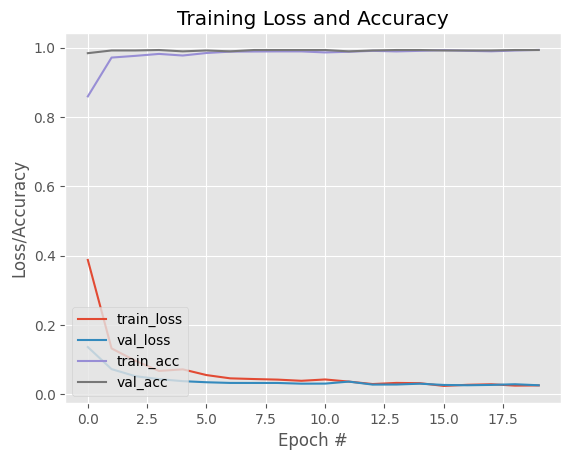

In [107]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")